In [1]:
import pandas as pd
import numpy as np
import glob
import os
import random
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import datetime
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, LSTM, Flatten, BatchNormalization, Dropout
from keras.utils import to_categorical
import tensorflow as tf
# Load the TensorBoard notebook extension
%load_ext tensorboard

Using TensorFlow backend.


In [2]:
countriesOfInterest = ["HK", "JP", 'ZA', 'TN', 'TR', 'GB', 'MX', 'US', 'CO', 'EC', 'AU', 'NZ']
#countriesOfInterest = ["HK", 'TR', 'GB', 'MX', 'US', 'CO', 'NZ']
train_n = 500
val_n = 20
Category = "Country"
w_length = 500
enc = OneHotEncoder()
enc.fit(np.array(countriesOfInterest).reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [3]:
def split(X, cat):
    X = X.reset_index()
    new_pos = list(X.track_id.index[X.track_id.shift(1) != X.track_id]) # indices where the song changes
    new_pos.append(max(X.track_id.index) + 1) # add a new index to know where the last song ends
    split_pos = []
    for i in range(len(new_pos)-1):
        split_pos = split_pos + list(range(new_pos[i], new_pos[i+1], w_length))
    split_pos = split_pos[1:]
    us_train = np.split(X.iloc[:,:24].to_numpy(), split_pos)
    labs = np.split(X[Category].to_numpy(), split_pos)
    # drop the short sequences
    short_seqs = []
    temp = [] 
    labels = []
    for i, value in enumerate(us_train):
        if value.shape[0] == w_length:
            temp.append(value)
            labels.append(labs[i][0])
    us_train = temp
    return np.stack(us_train), labels

In [4]:
def splitSeconds(n, country, t):
    data = pickle.load( open( "Raw Track Data\\" + country + "_" + t + ".p", "rb" ) )
    tracks = data.track_id.unique()
    tracks = np.random.choice(tracks, size=n, replace=True)
    samples = []
    for track in tracks:
        try:
            trackFeats = data[data.track_id == track]
            FeatsLen =  trackFeats.shape[0]
            #ind = np.random.choice(trackFeats.index[:-5], size=1, replace=True)
            ind = random.randrange(1, FeatsLen - 10)
            example = np.empty((0,24))
            while len(example) < w_length:
                feats = np.array(trackFeats.iloc[ind].loc["p1":"t12"])
                reps = int(trackFeats.iloc[ind].loc["duration"] * 100)
                if reps > 0:
                    hold = np.tile(feats, reps).reshape(reps, -1)
                    example = np.append(example, hold, axis = 0)
                ind = ind + 1
              #  example = np.array(example)
                example = example[-w_length:]
            samples = samples + [example]
        except:
            continue
    samples = np.array(samples)
    return samples, np.repeat(np.array([country]), samples.shape[0])

In [5]:
def getSamples(train_n, val_n):
    train = pd.DataFrame()
    train_labels = pd.DataFrame()
    val = pd.DataFrame()
    val_labels = pd.DataFrame()
    train_x = []
    train_labels = []
    val_x = []
    val_labels = []
    for country in countriesOfInterest:
        x1, y1 = splitSeconds(train_n, country, "train")
        x2, y2 = splitSeconds(val_n, country, "val")
        train_x = train_x + x1.tolist()
        train_labels = train_labels + y1.tolist()
        val_x = val_x + x2.tolist()
        val_labels = val_labels + y2.tolist()
    train_x = np.array(train_x)
    train_labels = np.array(train_labels)
    val_x = np.array(val_x)
    val_labels = np.array(val_labels)
    class_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(train_labels),
                                                     list(train_labels))
    train_labels = enc.transform(np.array(train_labels).reshape(-1,1)).toarray()
    val_labels = enc.transform(np.array(val_labels).reshape(-1,1)).toarray()
    return train_x, train_labels, val_x, val_labels, class_weights

In [6]:
train_x, train_labels, val_x, val_labels, class_weights = getSamples(1, 1)

### Fit model

In [7]:
enc.categories_

[array(['AU', 'CO', 'EC', 'GB', 'HK', 'JP', 'MX', 'NZ', 'TN', 'TR', 'US',
        'ZA'], dtype='<U2')]

In [8]:
model = keras.Sequential()
model.add(LSTM(50, 
               input_shape=(train_x.shape[1], train_x.shape[2]), 
               return_sequences = True,
              recurrent_dropout = .5))
model.add(LSTM(100, 
               input_shape=(train_x.shape[1], train_x.shape[2]), 
               return_sequences = False,
             recurrent_dropout = .5,
              go_backwards = True))
model.add(BatchNormalization())
#model.add(Dropout(.5))
#model.add(Dense(50, activation= "relu"))
#model.add(BatchNormalization())
#model.add(Dropout(.5))
#model.add(Dense(50, activation= "relu"))
#model.add(BatchNormalization())
model.add(Dropout(.5))
model.add(Dense(len(enc.categories_[0]), activation= "softmax"))
adam = keras.optimizers.Adam(lr=0.0001)
model.compile(loss = "categorical_crossentropy", optimizer= adam, metrics=["acc"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500, 50)           15000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 77,012
Trainable params: 76,812
Non-trainable params: 200
_________________________________________________________________
None


240/240 [==============================] - 0s 2ms/sample
[100. 100. 100. 100.  97. 100. 100. 100. 100. 100.  98. 100.]


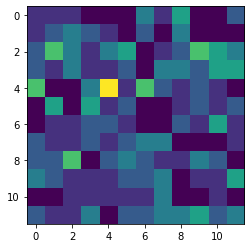

1195/1195 [==============================] - 1s 1ms/sample


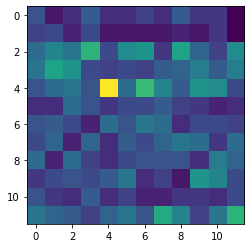

237/237 [==============================] - 0s 2ms/sample
[100. 100. 100. 100.  97. 100. 100. 100. 100. 100.  98. 100.]


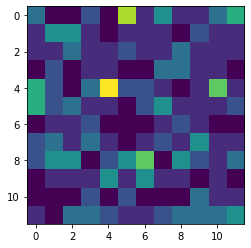

1195/1195 [==============================] - 2s 2ms/sample


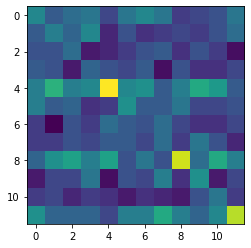

In [ ]:
log_dir = os.path.join(
    "logs",
    "fit",
    "greedy",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)
train_n = 100
val_n = 20
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
epochs = 10
iterations = 200
for i in range(iterations):
    train_x, train_labels, val_x, val_labels, class_weights = getSamples(train_n, val_n)
    model.fit(train_x, train_labels,
              epochs = i * epochs + epochs, 
              initial_epoch = i * epochs,
              shuffle = True,
              validation_data = (val_x, val_labels),
              batch_size = 128,
              class_weight = class_weights,
             callbacks=[tensorboard_callback],
             verbose = 0)
    if i % 10 == 0:
        preds = model.predict(val_x, batch_size = 256, verbose = 1)
        print(np.sum(train_labels, axis = 0))
        plt.imshow(
            confusion_matrix(
                enc.inverse_transform(preds), 
                enc.inverse_transform(val_labels), 
               # normalize = "all"
            )
        )
        plt.pause(.5)
        plt.show()
        preds = model.predict(train_x, batch_size = 256, verbose = 1)
        plt.imshow(
            confusion_matrix(
                enc.inverse_transform(preds), 
                enc.inverse_transform(train_labels), 
            #    normalize = "all"
            )
        )
        plt.pause(.5)
        plt.show()

In [ ]:
model.pop()
for layer in model.layers:
    layer.trainable = False
model.add(Dense(50, activation= "relu"))
model.add(BatchNormalization())
model.add(Dropout(.5))
model.add(Dense(len(enc.categories_[0]), activation= "softmax"))
adam = keras.optimizers.Adam(lr=0.0001)
model.compile(loss = "categorical_crossentropy", optimizer= adam, metrics=["acc"])
print(model.summary())

In [ ]:
log_dir = os.path.join(
    "logs",
    "fit",
    "greedy",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)
train_n = 100
val_n = 20
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
epochs = 10
iterations = 100
for i in range(iterations):
    train_x, train_labels, val_x, val_labels, class_weights = getSamples(train_n, val_n)
    model.fit(train_x, train_labels,
              epochs = i * epochs + epochs, 
              initial_epoch = i * epochs,
              shuffle = True,
              validation_data = (val_x, val_labels),
              batch_size = 128,
              class_weight = class_weights,
             callbacks=[tensorboard_callback],
             verbose = 0)
    if i % 10 == 0:
        preds = model.predict(val_x, batch_size = 256, verbose = 1)
        print(np.sum(train_labels, axis = 0))
        plt.imshow(
            confusion_matrix(
                enc.inverse_transform(preds), 
                enc.inverse_transform(val_labels), 
               # normalize = "all"
            )
        )
        plt.pause(.5)
        plt.show()
        preds = model.predict(train_x, batch_size = 256, verbose = 1)
        plt.imshow(
            confusion_matrix(
                enc.inverse_transform(preds), 
                enc.inverse_transform(train_labels), 
            #    normalize = "all"
            )
        )
        plt.pause(.5)
        plt.show()

In [ ]:
model.pop()
for layer in model.layers:
    layer.trainable = False
model.add(Dense(50, activation= "relu"))
model.add(BatchNormalization())
model.add(Dropout(.5))
model.add(Dense(len(enc.categories_[0]), activation= "softmax"))
adam = keras.optimizers.Adam(lr=0.0001)
model.compile(loss = "categorical_crossentropy", optimizer= adam, metrics=["acc"])
print(model.summary())

In [ ]:
log_dir = os.path.join(
    "logs",
    "fit",
    "greedy",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)
train_n = 100
val_n = 20
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
epochs = 10
iterations = 100
for i in range(iterations):
    train_x, train_labels, val_x, val_labels, class_weights = getSamples(train_n, val_n)
    model.fit(train_x, train_labels,
              epochs = i * epochs + epochs, 
              initial_epoch = i * epochs,
              shuffle = True,
              validation_data = (val_x, val_labels),
              batch_size = 128,
              class_weight = class_weights,
             callbacks=[tensorboard_callback],
             verbose = 0)
    if i % 10 == 0:
        preds = model.predict(val_x, batch_size = 256, verbose = 1)
        print(np.sum(train_labels, axis = 0))
        plt.imshow(
            confusion_matrix(
                enc.inverse_transform(preds), 
                enc.inverse_transform(val_labels), 
               # normalize = "all"
            )
        )
        plt.pause(.5)
        plt.show()
        preds = model.predict(train_x, batch_size = 256, verbose = 1)
        plt.imshow(
            confusion_matrix(
                enc.inverse_transform(preds), 
                enc.inverse_transform(train_labels), 
            #    normalize = "all"
            )
        )
        plt.pause(.5)
        plt.show()

In [ ]:
for layer in model.layers:
    layer.trainable = True

In [ ]:
log_dir = os.path.join(
    "logs",
    "fit",
    "greedy",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)
train_n = 1000
val_n = 200
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
epochs = 10
iterations = 100
for i in range(iterations):
    train_x, train_labels, val_x, val_labels, class_weights = getSamples(train_n, val_n)
    model.fit(train_x, train_labels,
              epochs = i * epochs + epochs, 
              initial_epoch = i * epochs,
              shuffle = True,
              validation_data = (val_x, val_labels),
              batch_size = 128,
              class_weight = class_weights,
             callbacks=[tensorboard_callback],
             verbose = 0)
    if i % 10 == 0:
        preds = model.predict(val_x, batch_size = 256, verbose = 1)
        print(np.sum(train_labels, axis = 0))
        plt.imshow(
            confusion_matrix(
                enc.inverse_transform(preds), 
                enc.inverse_transform(val_labels), 
               # normalize = "all"
            )
        )
        plt.pause(.5)
        plt.show()
        preds = model.predict(train_x, batch_size = 256, verbose = 1)
        plt.imshow(
            confusion_matrix(
                enc.inverse_transform(preds), 
                enc.inverse_transform(train_labels), 
            #    normalize = "all"
            )
        )
        plt.pause(.5)
        plt.show()